In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

C:\Users\alves\AppData\Local\Temp\ipykernel_23152\3778166921.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
fdtdAPI = lumapi.FDTD(hide = False)

## Parameters

In [3]:
# units
um = 1e-6
nm = 1e-9

In [4]:
# Materials 
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'

In [34]:
# MMI x parameters
# L = 57.42 * um
L = 59.2*um # otimizado
W = 7.0 * um

# Taper parameters
W1 = 450 * nm
W2 = 1.5 * um
L1 = 15 * um

# Waveguide parameters
wvg_width = 450 * nm
wvg_height = 220 * nm

# Waveguide length
wvg_length = 4.0 * um

# Bandwidth operation
cband = True
# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

filename = "S_MMI_FDTD_2x2_%d_um" % (L / um)

## Create Box MMI

In [ ]:
# Defining a Structure Group
fdtdAPI.addstructuregroup()
dev_layer = "GDS_LAYER 35:4"
fdtdAPI.set("name", dev_layer)

In [7]:
fdtdAPI.switchtolayout()
fdtdAPI.deleteall()

# Add box
fdtdAPI.addrect()
fdtdAPI.addtogroup(dev_layer)
fdtdAPI.set("name", "box")
fdtdAPI.set("x", 0)
fdtdAPI.set("x span", L)
fdtdAPI.set("y", 0)
fdtdAPI.set("y span", W)
fdtdAPI.set("z", 0)
fdtdAPI.set("z span", wvg_height)
fdtdAPI.set("material", core_material)

# Tapers Configuration
for i in range(4):
    fdtdAPI.addobject("linear_taper")
    fdtdAPI.set("name", f"taper port {str(i + 1)}")
    fdtdAPI.set("thickness", wvg_height)
    fdtdAPI.set("angle_side", 90)
    fdtdAPI.set("width_r", W1)
    fdtdAPI.set("width_l", W2)
    fdtdAPI.set("len", L1)
    fdtdAPI.set("material", core_material)
    fdtdAPI.set("x", fdtdAPI.getnamed(f"{dev_layer}::box", "x max") + L1/2)
    fdtdAPI.set("y", 0)
    fdtdAPI.set("z", 0)

# Adjusting taper positions
fdtdAPI.select(f"{dev_layer}::taper port 1")
fdtdAPI.set("width_r", W2)
fdtdAPI.set("width_l", W1)
fdtdAPI.set("x", -fdtdAPI.getnamed(f"{dev_layer}::box", "x max") - L1/2)
fdtdAPI.set("y", W/6)

fdtdAPI.select(f"{dev_layer}::taper port 2")
fdtdAPI.set("width_r", W2)
fdtdAPI.set("width_l", W1)
fdtdAPI.set("x", -fdtdAPI.getnamed(f"{dev_layer}::box", "x max") - L1/2)
fdtdAPI.set("y", -W/6)

fdtdAPI.select(f"{dev_layer}::taper port 3")
fdtdAPI.set("y", W/6)

fdtdAPI.select(f"{dev_layer}::taper port 4")
fdtdAPI.set("y", -W/6)

# add waveguides
for i in range(4):
    fdtdAPI.addrect()
    fdtdAPI.addtogroup(dev_layer)
    fdtdAPI.set("name", f"wvguide {str(i+1)}")
    fdtdAPI.set("x", 0)
    fdtdAPI.set("x span", wvg_length)
    fdtdAPI.set("y", 0)
    fdtdAPI.set("y span", wvg_width)
    fdtdAPI.set("z", 0)
    fdtdAPI.set("z span", wvg_height)
    fdtdAPI.set("material", core_material)

# Adjusting the wvg positions
fdtdAPI.select(f"{dev_layer}::wvguide 1")
fdtdAPI.set("x", fdtdAPI.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
fdtdAPI.set("y", W/6)

fdtdAPI.select(f"{dev_layer}::wvguide 2")
fdtdAPI.set("x", fdtdAPI.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
fdtdAPI.set("y", -W/6)

fdtdAPI.select(f"{dev_layer}::wvguide 3")
fdtdAPI.set("x", fdtdAPI.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
fdtdAPI.set("y", W/6)

fdtdAPI.select(f"{dev_layer}::wvguide 4")
fdtdAPI.set("x", fdtdAPI.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
fdtdAPI.set("y", -W/6)


## Add Solver

In [17]:
nmbrFrqPnts = 21

## Solver parameters
simulation_time = (2*wvg_length + 2*L1 + 10*L)/c

# Dimensões do volume do solver
x_FDTD = 0
y_FDTD = 0
z_FDTD = 0
x_span_FDTD = L + 2*L1 + wvg_length*1.7 
y_span_FDTD = W*2
z_span_FDTD = 4*um

# Precisão do mesh
mesh_accuracy = 2

# Condições de fronteira
z_min_bc = "Symmetric"

In [18]:
fdtdAPI.switchtolayout()
fdtdAPI.select('FDTD')
fdtdAPI.delete()
fdtdAPI.select('monitor')
fdtdAPI.delete()
fdtdAPI.select('movie')
fdtdAPI.delete()


# add solver
fdtdAPI.addfdtd()
fdtdAPI.set("x", x_FDTD)
fdtdAPI.set("x span", x_span_FDTD)
fdtdAPI.set("y", y_FDTD)
fdtdAPI.set("y span", y_span_FDTD)
fdtdAPI.set("z", z_FDTD)
fdtdAPI.set("z span", z_span_FDTD)
fdtdAPI.set("background material", sub_material)
fdtdAPI.set("mesh accuracy", mesh_accuracy)
fdtdAPI.set("simulation time", simulation_time)
fdtdAPI.set("z min bc", z_min_bc)

fdtdAPI.addprofile();
fdtdAPI.set('name', 'monitor');
fdtdAPI.set("x", x_FDTD)
fdtdAPI.set("x span", x_span_FDTD)
fdtdAPI.set("y", y_FDTD)
fdtdAPI.set("y span", y_span_FDTD)
fdtdAPI.set("z", z_FDTD)
fdtdAPI.set("override global monitor settings", True)
fdtdAPI.set("frequency points", nmbrFrqPnts)

fdtdAPI.addmovie()
fdtdAPI.set('name', 'movie')
fdtdAPI.set("x", x_FDTD)
fdtdAPI.set("x span", x_span_FDTD)
fdtdAPI.set("y", y_FDTD)
fdtdAPI.set("y span", y_span_FDTD)
fdtdAPI.set("z", z_FDTD)

In [20]:
# Ports parameters

y_span_port = wvg_width*4
z_span_port = wvg_height*4
mode_selection = "fundamental TE mode"
injection_axis = "x"

In [ ]:
# Add ports
fdtdAPI.switchtolayout()
fdtdAPI.select('FDTD::ports')
fdtdAPI.delete()

for i in range(4):
    fdtdAPI.addport()
    fdtdAPI.set('name', 'port' + str(i+1))
    fdtdAPI.set('injection axis', injection_axis)
    fdtdAPI.set('x', (L/2 + L1 + wvg_length - 1.5*um)*(-1)**(i+1))
    fdtdAPI.set('y', W/6)
    fdtdAPI.set('z', z_FDTD)
    fdtdAPI.set('y span', y_span_port)
    fdtdAPI.set('z span', z_span_port)
    fdtdAPI.set('direction', 'Forward')

# Adjusting the ports
fdtdAPI.select('FDTD::ports::port3')
fdtdAPI.set('y', -W/6)

fdtdAPI.select('FDTD::ports::port4')
fdtdAPI.set('y', -W/6)

In [32]:
fdtdAPI.setnamed("FDTD", "global source wavelength start", wvlngth_start)
fdtdAPI.setnamed("FDTD", "global source wavelength stop", wvlngth_stop)
fdtdAPI.setnamed("FDTD::ports", "monitor frequency points", nmbrFrqPnts)

In [36]:
fdtdAPI.save(f'C:/Users/alves/Documents/{filename}')

fdtdAPI.run()

## Field profile

C:\Users\alves\AppData\Local\Temp\ipykernel_23152\1632166503.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title(r'%4.3f $\mu$m' % (lmbd[indxLambda] / um), fontsize=15)


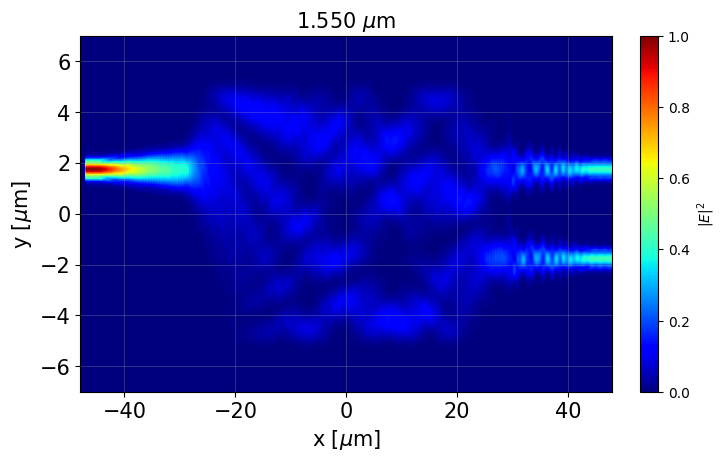

In [87]:
# Imports the electric field - abs^2.
eField = np.abs(np.squeeze(fdtdAPI.getelectric("monitor")))

# It shows the electric field obtained.
indxLambda = 9
x_eField = fdtdAPI.getdata("monitor", "x")
y_eField = fdtdAPI.getdata("monitor", "y")
lmbd = nu2lambda(fdtdAPI.getdata("monitor", "f"))
xmin = 1e6 * np.min(x_eField)
xmax = 1e6 * np.max(x_eField)
ymin = 1e6 * np.min(y_eField)
ymax = 1e6 * np.max(y_eField)

# Escala linear.
fig1 = plt.figure(figsize=(8,4))
ax1 = fig1.add_subplot(111)
im1 = ax1.imshow(np.rot90(eField[:, :, indxLambda]), cmap='jet', extent=[xmin, xmax, ymin, ymax], vmin=0, vmax=1)

colorbar = plt.colorbar(im1, fraction=0.2, pad=0.04)
colorbar.set_label(r'$|E|^2$')

ax1.set_xlabel(r'x [$\mu$m]', fontsize=15)
ax1.set_ylabel(r'y [$\mu$m]', fontsize=15)
ax1.set_title(r'%4.3f $\mu$m' % (lmbd[indxLambda] / um), fontsize=15)
ax1.grid(which='major', alpha=0.25)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
ax1.set_aspect('auto')
plt.savefig('fdtd TE eField linear.png', bbox_inches='tight')

plt.show()


C:\Users\alves\AppData\Local\Temp\ipykernel_23152\1265196773.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title(r'%4.3f $\mu$m' % (lmbd[indxLambda] / um), fontsize=15)


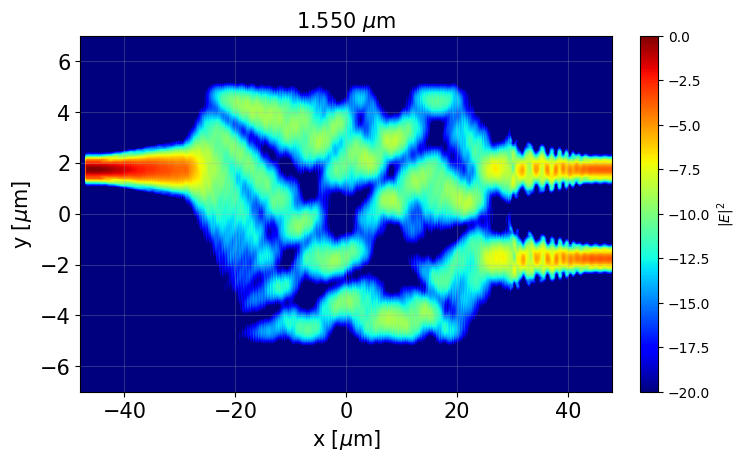

In [88]:
# Escala log.
fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(111)
im2 = ax1.imshow(10 * np.log10(np.rot90(eField[:, :, indxLambda])), cmap='jet', extent=[xmin, xmax, ymin, ymax], vmin=-20, vmax=0)

colorbar = plt.colorbar(im2, fraction=0.2, pad=0.04)
colorbar.set_label(r'$|E|^2$')

ax1.set_xlabel(r'x [$\mu$m]', fontsize=15)
ax1.set_ylabel(r'y [$\mu$m]', fontsize=15)
ax1.set_title(r'%4.3f $\mu$m' % (lmbd[indxLambda] / um), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(which='major', alpha=0.25)

plt.tight_layout()

ax1.set_aspect('auto')
plt.savefig('fdtd TE eField log.png', bbox_inches='tight')
plt.show()


## Transmission

In [40]:
port2 = fdtdAPI.getresult("FDTD::ports::port2", "T")
port4 = fdtdAPI.getresult("FDTD::ports::port4", "T")

T2 = np.abs(port2['T'])
T4 = np.abs(port4['T'])
Lambda = port2['lambda']/nm

T2_dB = 10*np.log10(T2)
T4_dB = 10*np.log10(T4)

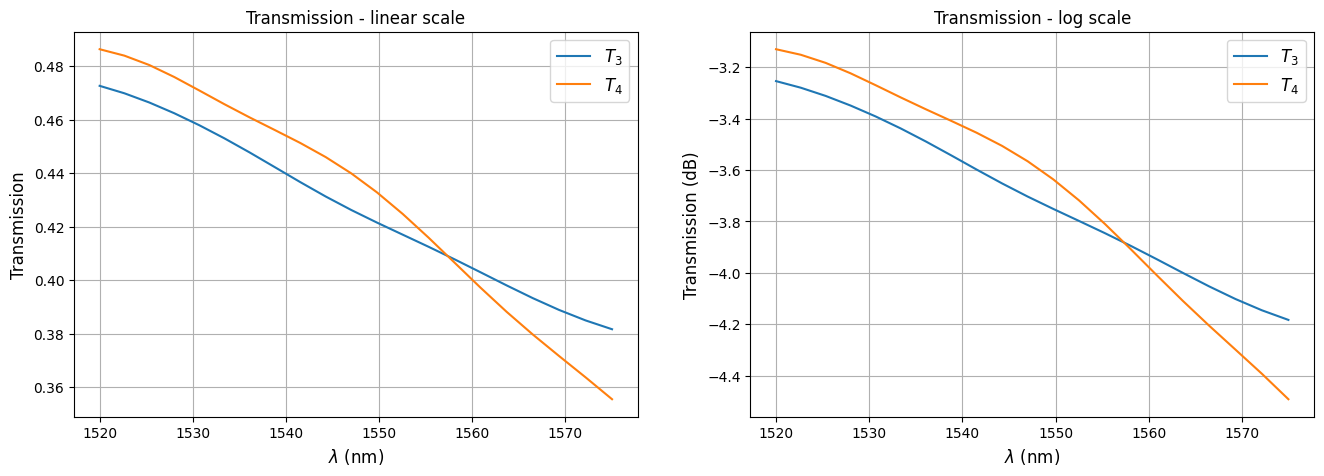

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(Lambda, T2, lw=1.5, label='$T_3$')
axs[0].plot(Lambda, T4, lw=1.5, label='$T_4$')
axs[0].set_xlabel('$\lambda$ (nm)', fontsize=12)
axs[0].set_ylabel('Transmission', fontsize=12)
axs[0].set_title('Transmission - linear scale')
axs[0].legend(fontsize=12)
# axs[0].set_ylim([0,0.5])
axs[0].grid()

axs[1].plot(Lambda, T2_dB, lw=1.5, label='$T_3$')
axs[1].plot(Lambda, T4_dB, lw=1.5, label='$T_4$')
axs[1].set_xlabel('$\lambda$ (nm)', fontsize=12)
axs[1].set_ylabel('Transmission (dB)', fontsize=12)
axs[1].set_title('Transmission - log scale')
# axs[1].set_ylim([-4,0])
axs[1].legend(fontsize=12)
axs[1].grid()

plt.savefig('fdtd TE eField transmission.png', bbox_inches='tight')


C:\Users\alves\AppData\Local\Temp\ipykernel_23152\200181172.py:14: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width="30%", height="30%", loc="upper right", bbox_transform=axs.transAxes)


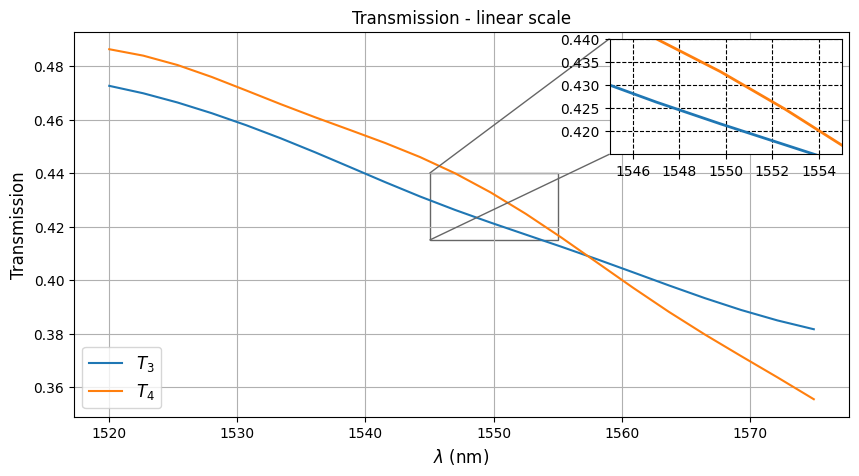

In [90]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(figsize=(10, 5))

axs.plot(Lambda, T2, lw=1.5, label='$T_3$')
axs.plot(Lambda, T4, lw=1.5, label='$T_4$')
axs.set_xlabel('$\lambda$ (nm)', fontsize=12)
axs.set_ylabel('Transmission', fontsize=12)
axs.set_title('Transmission - linear scale')
axs.legend(loc='lower left', fontsize=12)
# axs.set_ylim([0,0.5])
axs.grid()

axins = inset_axes(axs, width="30%", height="30%", loc="upper right", bbox_transform=axs.transAxes)


axins.plot(Lambda, T2, lw=2, label="$T_3$")
axins.plot(Lambda, T4, lw=2, label="$T_4$")
axins.set_xlim(1545, 1555)  
axins.set_ylim(0.415, 0.44)  
axins.grid(True, color='black', linestyle='--')  
axins.set_yticks(np.arange(0.42, 0.44, step=0.005))
# axins.set_xticks(np.arange(1545, 1555, step=2.5)) 

mark_inset(axs, axins, loc1=2, loc2=3, fc="none", ec="0.4")

plt.savefig('fdtd Transmission_FDTD_TE_zoom')

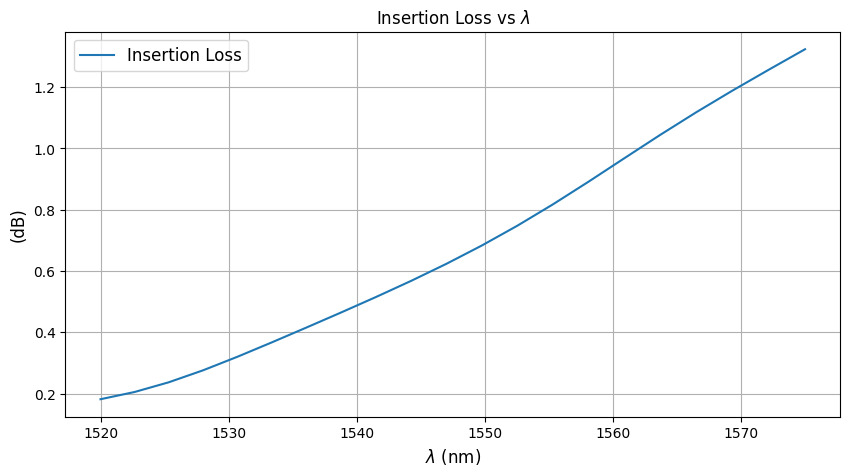

In [92]:
fig, axs = plt.subplots(figsize=(10, 5))

insertion = -10*np.log10(T2+T4)

axs.plot(Lambda, insertion, lw=1.5, label='Insertion Loss')
# axs.plot(Lambda/nm, T4, lw=1.5, label='$T_4$')
axs.set_xlabel('$\lambda$ (nm)', fontsize=12)
axs.set_ylabel('(dB)', fontsize=12)
axs.set_title('Insertion Loss vs $\lambda$')
axs.legend(fontsize=12)
# axs.set_ylim([0,0.5])
axs.grid()

plt.savefig('fdtd InsertionLoss_FDTD_TE')